In [1]:
#%matplotlib ipympl
import numpy as np
from mask_utils import *
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
mask, hdmask = read_mask_bulk('wfm_mask.fits', 2, header_out=True, verbose=False)
rmatrix = read_mask_bulk('wfm_mask.fits', 3, verbose=False)
bulk = read_mask_bulk('wfm_mask.fits', 4, verbose=False)

In [3]:
fx = 1
fy= 1
mask=upscale(mask, fx, fy)
bulk=upscale(bulk, fx, fy)
print(np.sum(bulk))
rmatrix = upscale(rmatrix, fx, fy)
bulk[bulk < 1] = 0
print(np.sum(bulk))

182208.11458912492
181300.0


In [4]:
#Gets mask information and define X, Y vectors (centers and edges)
ELXDIM = hdmask['ELXDIM'] / fx
ELYDIM = hdmask['ELYDIM'] / fy
ELXN   = hdmask['ELXN'] * fx
ELYN   = hdmask['ELYN'] * fy

In [5]:
#Defines FITS event file
#fdet = "cxb_2-50keV_10ks_infthinmask_cam1a_detected.fits"
fdet = "cxb_2-50keV_10ks_cam1a_detected.fits"


In [6]:
det, hdet0, hdet1 = read_fits_events(fdet, header0=True, header1=True, verbose=False)
xedges, yedges = get_detimage_edges(ELXDIM, ELYDIM, ELXN, ELYN)

#Computes detector image
detimage = get_detimage(det, xedges, yedges) * bulk

In [7]:
#First of all we calculate the total detector counts and total active elelements
sum_det = np.sum(detimage)


#Then we "estimate" the background shape on the detector image considering only the system geometry 
# (i.e. the solid angle seen by each active pixel)
omega = solid_angle(bulk, ELXDIM, ELYDIM, 202.9+0.150/2)
#and we normalize it to have a sum(omega) = 1

omega[detimage <=0] = 0
omega_norm = omega/np.sum(omega)

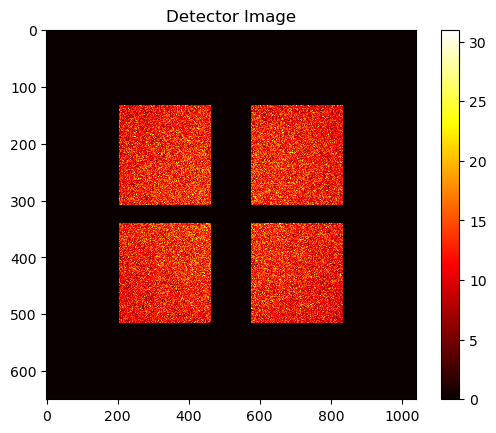

In [8]:
#Showing detimage
fig, ax = plt.subplots()
ax.set_title("Detector Image")
im = ax.imshow(detimage.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax)
plt.show()

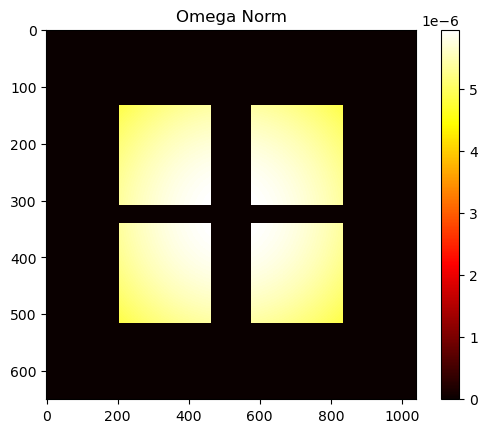

In [9]:
#Showing omega
fig, ax = plt.subplots()
ax.set_title("Omega Norm")
im = ax.imshow(omega_norm.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax)
plt.show()

In [10]:
from scipy.optimize import minimize

def renorm(x, y, a, b, c):
    return a*x + b*y + c

def loss(args):



    
    norm = args[0]
    a = args[1]
    b = args[2]
    c = args[3]
    
    Lambda = (omega_norm * bulk * args[0] )
    x = np.linspace(0, 1, detimage.shape[1])
    y = np.linspace(0, 1, detimage.shape[0])
    xs, ys = np.meshgrid(x, y)

    grad = renorm(xs, ys, a, b, c) * bulk

    Lambda_renorm = Lambda * grad
    
    mae = np.sum( np.square(detimage - Lambda_renorm))
    
    return mae

guess = [sum_det*0.9, -1, -1, 0]
results = minimize(loss, guess, method="L-BFGS-B", 
                    bounds=[
                    (0.90 * sum_det, 1.* sum_det) , (-10, 10), (-10, 10), (-10, 10)
                    ],
                   options={
                       "maxiter": 100,
                       "ftol": 1e-12,
                       "gtol": 1e-12
                   }
                  )

In [11]:
print(results)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2304825.721271542
        x: [ 2.065e+06 -3.056e-02 -4.063e-02  1.147e+00]
      nit: 6
      jac: [ 0.000e+00  0.000e+00  0.000e+00  9.313e-02]
     nfev: 55
     njev: 11
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


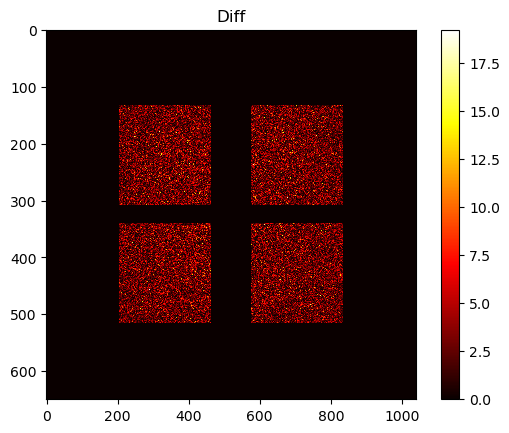

In [12]:
#Showing diff
fig, ax = plt.subplots()
ax.set_title("Diff")
diff = np.abs(detimage - omega_norm * results.x[0] )
im = ax.imshow(diff.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax)
plt.show()

In [13]:
xedges, yedges = get_detimage_edges(ELXDIM, ELYDIM, ELXN, ELYN)
detimage = get_detimage(det, xedges, yedges)
omega = solid_angle(bulk, ELXDIM, ELYDIM, 202.9) * bulk
omega_norm = omega/np.sum(omega) 

x = np.linspace(0, 1, detimage.shape[1])
y = np.linspace(0, 1, detimage.shape[0])
xs, ys = np.meshgrid(x, y)
grad = renorm(xs, ys, results.x[1],results.x[2],results.x[3], )
Lambda = omega_norm*results.x[0] * grad



skyimage = decode(detimage, rmatrix, bulk)
skylambda = decode(Lambda, rmatrix, bulk) 
skydiff = decode( (detimage - Lambda ), rmatrix, bulk)

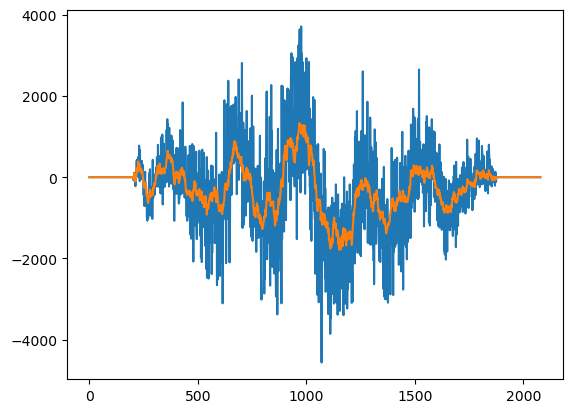

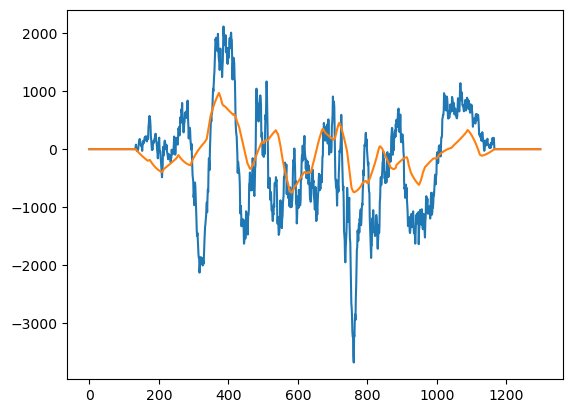

In [14]:
center = (1039, 649)

plt.figure()
plt.plot(skyimage[:, center[1]])
plt.plot(skylambda[:, center[1]])
plt.show()

plt.figure()
plt.plot(skyimage[center[0], : ])
plt.plot(skylambda[center[0]+0, : ])
plt.show()




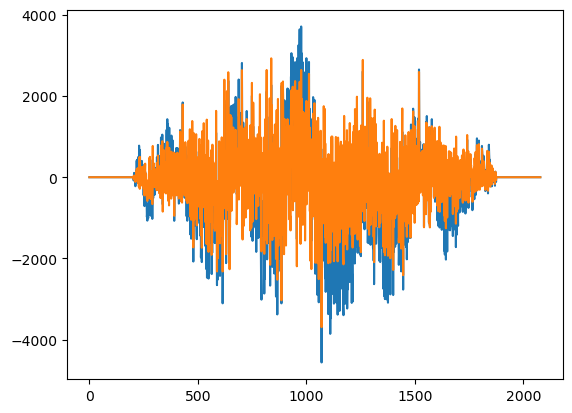

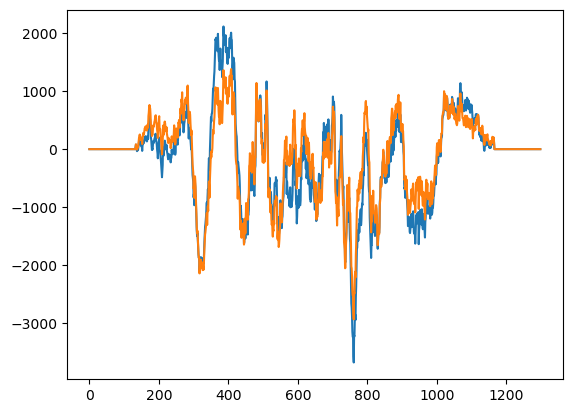

In [15]:
plt.close()
plt.figure()
plt.plot(skyimage[:, center[1]])
plt.plot(skydiff[:, center[1]])
plt.show()

plt.figure()
plt.plot(skyimage[center[0], : ])
plt.plot(skydiff[center[0], : ])
plt.show()

In [16]:
collapsed_y =   Lambda.sum(axis=0)
collapsed_x =   Lambda.sum(axis=1)

In [17]:
from scipy import ndimage
detcollapsed_y = detimage.sum(axis=0)
detcollapsed_x = detimage.sum(axis=1)


appo_y = ndimage.median_filter(detcollapsed_y[detcollapsed_y>0], size=2)
appo_x = ndimage.median_filter(detcollapsed_x[detcollapsed_x>0], size=2)

filtered_y = np.ones(detcollapsed_y.shape)*detcollapsed_y
filtered_y[detcollapsed_y>0] = appo_y

filtered_x = np.ones(detcollapsed_x.shape)*detcollapsed_x
filtered_x[detcollapsed_x>0] = appo_x



filtered_y_norm = filtered_y/np.sum(filtered_y)
filtered_x_norm = filtered_x/np.sum(filtered_x)





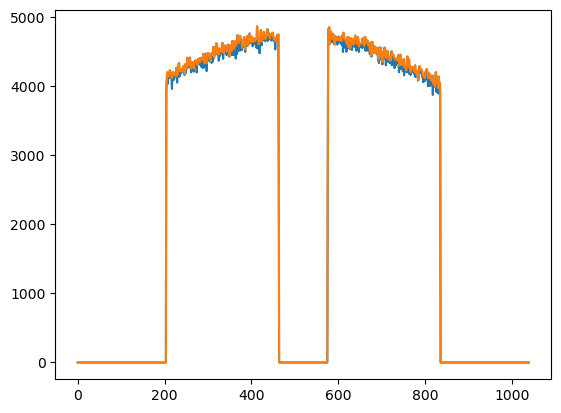

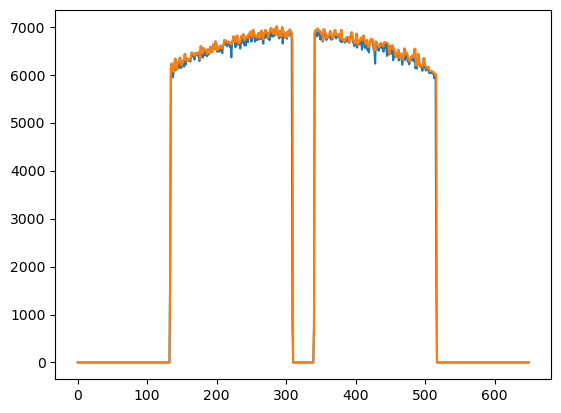

In [18]:
plt.close()
plt.figure()
#plt.plot(collapsed_x)
plt.plot(detcollapsed_x)
plt.plot(filtered_x)


#plt.ylim(4000,6000)
#plt.xlim(45,215)
plt.show()

plt.close()
plt.figure()
#plt.plot(collapsed_y)
plt.plot(detcollapsed_y)
plt.plot(filtered_y)
#plt.ylim(25000,35000)
#plt.xlim(30,130)

plt.show()

In [19]:
filtered_x_norm_2d = (np.tile(filtered_x_norm, (650,1))).T
filtered_y_norm_2d = (np.tile(filtered_y_norm, (1040, 1)))

filtered_norm_2d = filtered_x_norm_2d * filtered_y_norm_2d * bulk
filtered_norm_2d /= np.sum(filtered_norm_2d)

print(shape(filtered_x_norm_2d))
print(shape(filtered_y_norm_2d))
print(shape(detimage))

(1040, 650)
(1040, 650)
(1040, 650)


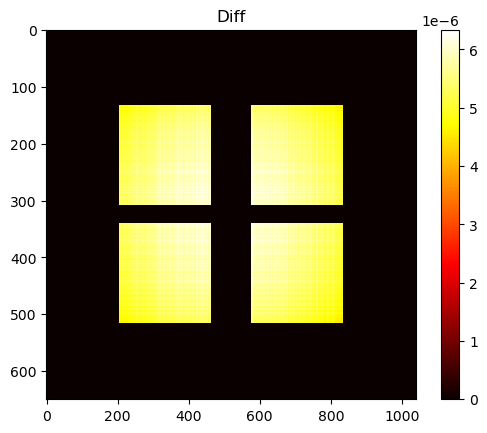

In [20]:
fig, ax = plt.subplots()
ax.set_title("Diff")
im = ax.imshow(filtered_norm_2d.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax)
plt.show()

In [21]:
filtcollapsed_y = filtered_norm_2d.sum(axis=0)
filtcollapsed_x = filtered_norm_2d.sum(axis=1)

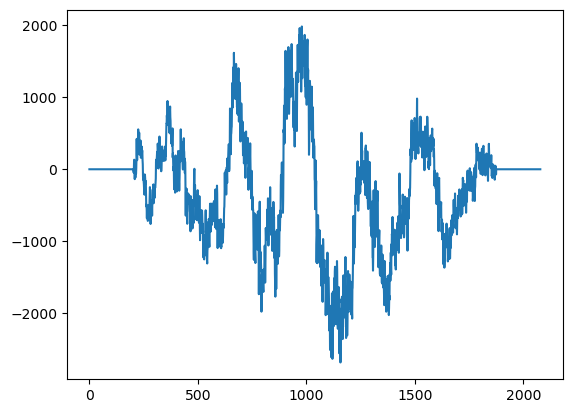

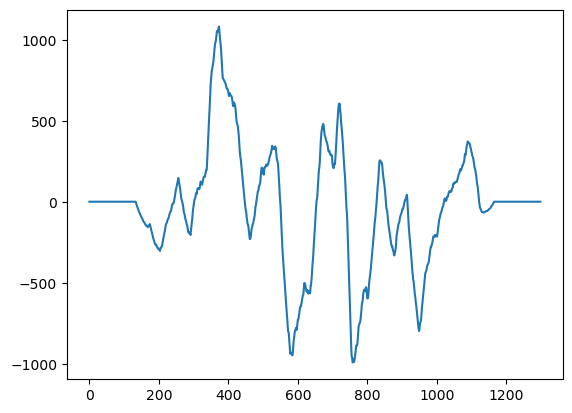

In [22]:
skyfilt = decode(filtered_norm_2d * np.sum(detimage), rmatrix, bulk) 
skydiff = decode( (detimage - filtered_norm_2d * np.sum(detimage) ), rmatrix, bulk)

plt.figure()
plt.plot(skyfilt[:, center[1]])
plt.show()

plt.figure()
plt.plot(skyfilt[center[0], : ])
plt.show()

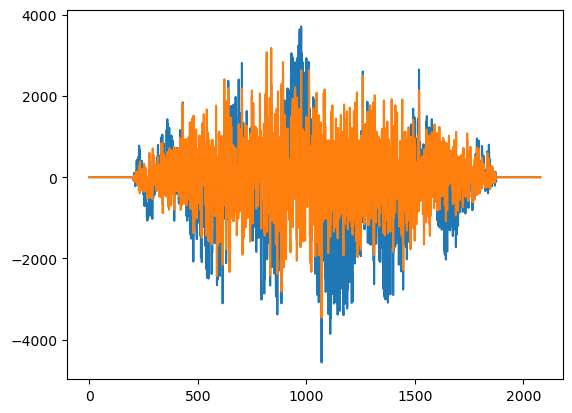

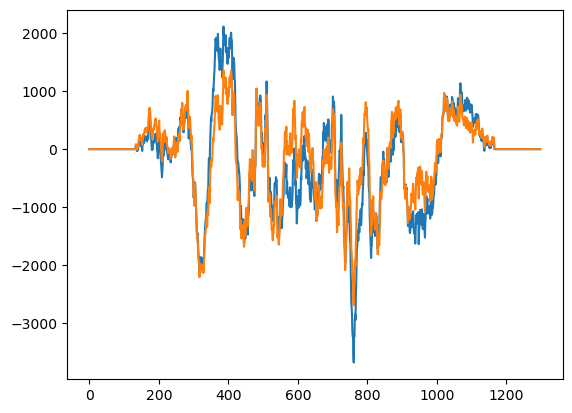

In [23]:
plt.figure()
plt.plot(skyimage[:, center[1]])
plt.plot(skydiff[:, center[1]])
plt.show()

plt.figure()
plt.plot(skyimage[center[0], : ])
plt.plot(skydiff[center[0]+0, : ])
plt.show()

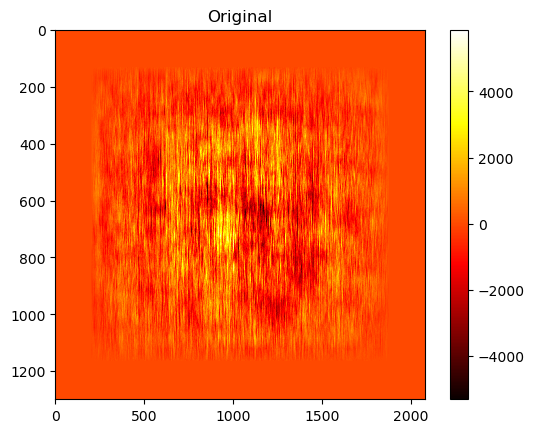

In [24]:
fig, ax = plt.subplots()
ax.set_title("Original")
im = ax.imshow(skyimage.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax)
plt.show()

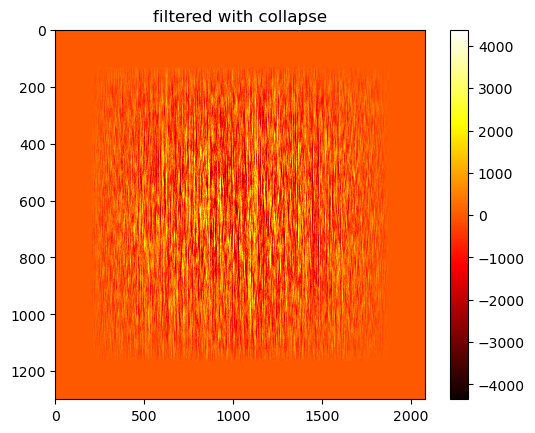

In [25]:
fig, ax = plt.subplots()
ax.set_title("filtered with collapse")
im = ax.imshow(skydiff.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax)
plt.show()

In [26]:
from scipy.signal import medfilt
filtered_2d = medfilt(detimage, kernel_size=(5,5))

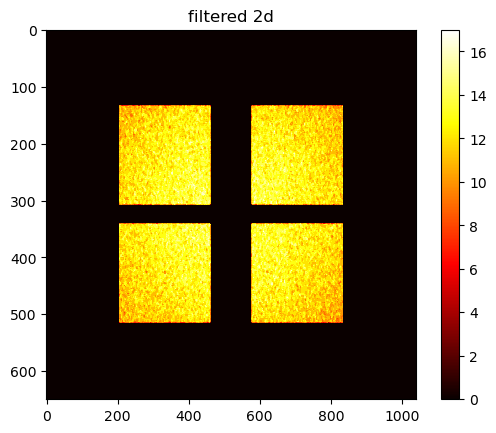

In [27]:
fig, ax = plt.subplots()
ax.set_title("filtered 2d")
im = ax.imshow(filtered_2d.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax)
plt.show()

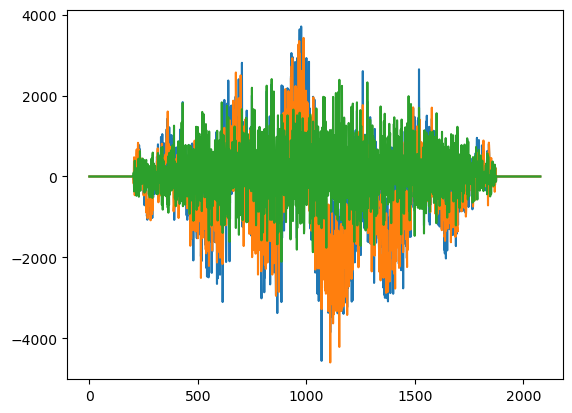

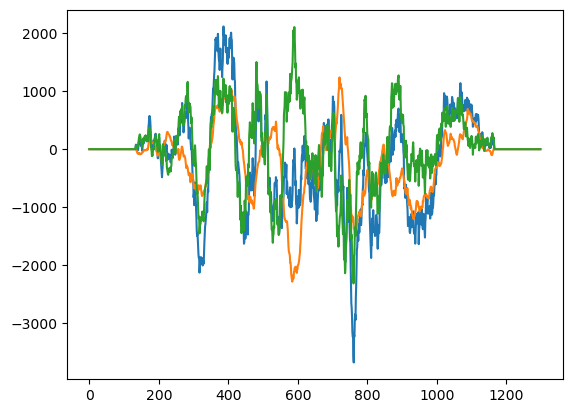

In [28]:
skyfilt = decode(filtered_2d , rmatrix, bulk) 
skydiff = decode( (detimage - filtered_2d ), rmatrix, bulk)

plt.figure()

plt.plot(skyimage[:, center[1]])
plt.plot(skyfilt[:, center[1]])
plt.plot(skydiff[:, center[1]])

plt.show()

plt.figure()
plt.plot(skyimage[center[0], : ])
plt.plot(skyfilt[center[0], : ])
plt.plot(skydiff[center[0], : ])
plt.show()

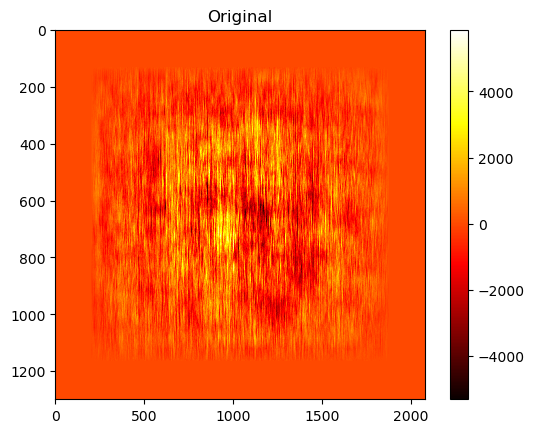

In [29]:
fig, ax = plt.subplots()
ax.set_title("Original")
im = ax.imshow(skyimage.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax)
plt.show()

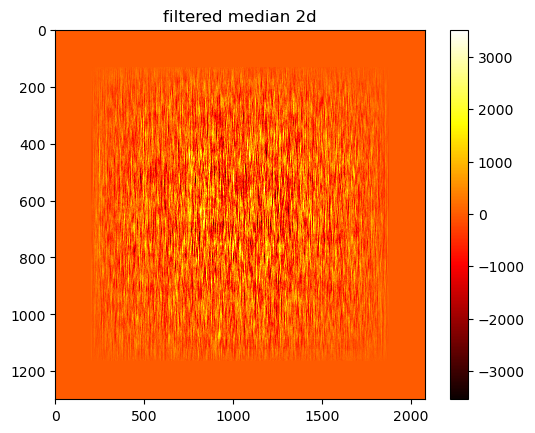

In [30]:
fig, ax = plt.subplots()
ax.set_title("filtered median 2d")
im = ax.imshow(skydiff.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax)
plt.show()

12.71399889685604


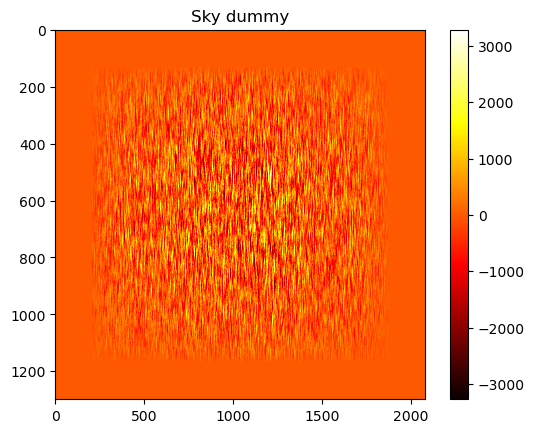

In [32]:
mean_rate = np.sum(detimage)/np.sum(bulk) 
print(mean_rate)
detimage_dummy = np.random.poisson(lam=mean_rate, size=detimage.shape) * bulk
sky_dummy = decode(detimage_dummy, rmatrix, bulk) 
fig, ax = plt.subplots()
ax.set_title("Sky dummy")
im = ax.imshow(sky_dummy.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax)
plt.show()